In [3]:
import torch
from torch import nn
import numpy as np
import dlc_practical_prologue as prologue

In [4]:
N=1000
epochs=25
mini_batch_size = 100

In [99]:
class SharedWeight(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=1),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2, stride=1))
        
        #predict implicitely the class
        self.fc1 = nn.Sequential(
            nn.Linear(7744, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
            nn.Softmax(1))
        
        #predict the output from concatenated classes predictions
        self.fc2 = nn.Sequential(
            nn.Linear(20, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10,2),
            nn.Softmax(1))
        
    def forward_once(self, x):
        #call the classification block on an individual input
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        #call the network on both input, combine the outputs and final output
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = self.fc2(torch.cat((output1, output2), 1))
        return output, output1, output2

def train_model(model, input_, target_, classes_=None, learn_rate_= 1e-2, lambda_=0.1, mini_batch_size=100, nb_epochs = 25):
    #classification & binary output
    criterion = nn.CrossEntropyLoss()
    
    #stochastic gradient descent
    optim = torch.optim.SGD(model.parameters(), lr=learn_rate_, momentum=0.9)

    for e in range(nb_epochs):
        for b in range(0, input_.size(0), mini_batch_size):
            #split the input in two, return the binary value and the classes of both input
            output, class_0, class_1 = model(input_.narrow(0, b, mini_batch_size)[:,0,:].unsqueeze(1),
                                             input_.narrow(0, b, mini_batch_size)[:,1,:].unsqueeze(1))
            
            if classes_ is None:
                #no auxiliary loss
                loss = criterion(output, target_.narrow(0, b, mini_batch_size))
            else:
                #auxiliary loss
                loss = criterion(output, target_.narrow(0, b, mini_batch_size)) \
                        + lambda_*criterion(class_0, classes_.narrow(0, b, mini_batch_size)[:,0]) \
                        + lambda_*criterion(class_1, classes_.narrow(0, b, mini_batch_size)[:,1])
            
            #backprop
            optim.zero_grad()
            loss.backward()
            optim.step()
    return loss
        
def compute_nb_errors(model, input_, target_, mini_batch_size):
    nb_error = 0
    
    for b in range(0, input_.size(0), mini_batch_size):
        output, _, _ = model(input_.narrow(0, b, mini_batch_size)[:,0,:].unsqueeze(1),
                       input_.narrow(0, b, mini_batch_size)[:,1,:].unsqueeze(1))
        _,pred = output.max(1)
        
        for k in range(mini_batch_size):
            if target_[b+k] != pred[k]:
                nb_error += 1
                
    return nb_error

In [100]:
Siamese = SharedWeight()

In [ ]:
train_input, train_target, train_classes, \
test_input, test_target, test_classes = \
    prologue.generate_pair_sets(N)

In [101]:
train_model(Siamese, train_input, train_target, train_classes, learn_rate_= 2e-2, lambda_=0.1, mini_batch_size=mini_batch_size, nb_epochs = 25)

tensor(0.7580, grad_fn=<AddBackward0>)

In [102]:
nb_test_errors = compute_nb_errors(Siamese, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                  nb_test_errors, test_input.size(0)))

test error Net 10.80% 108/1000


In [32]:
learn_rates = np.geomspace(1e-4, 1e-1,20)
lambdas = np.geomspace(1e-4, 1e-1,20)
losses_train = []
train_error = []
test_error = []
#for lr in learn_rates:
for lbd in lambdas:
    Siamese = SharedWeight()
    train_input, train_target, train_classes, \
    test_input, test_target, test_classes = \
    prologue.generate_pair_sets(N)
    losses_train.append(train_model(Siamese, train_input, train_target, train_classes, learn_rate_= 2e-2, lambda_=lbd, mini_batch_size=mini_batch_size, nb_epochs = 25))
    train_error.append(compute_nb_errors(Siamese, train_input, train_target, mini_batch_size))
    test_error.append(compute_nb_errors(Siamese, test_input, test_target, mini_batch_size))

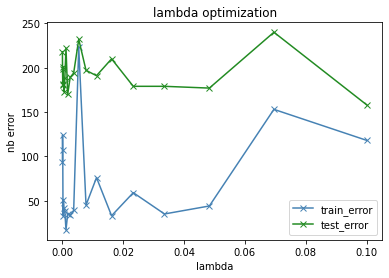

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(lambdas, train_error,c='steelblue',label="train_error", marker='x')
plt.plot(lambdas, test_error,c='forestgreen', label="test_error", marker='x')
plt.title("lambda optimization")
plt.xlabel("lambda")
plt.ylabel("nb error")
plt.legend()
plt.show()
#fig.savefig("lambda_opti.png") # Use fig. here

In [34]:
lambdas[np.argmin(test_error)]

0.1

In [103]:
losses_train = []
train_error = []
test_error = []
for i in range(10):
    train_input, train_target, train_classes, \
    test_input, test_target, test_classes = \
    prologue.generate_pair_sets(N)
    Siamese = SharedWeight()
    losses_train.append(train_model(Siamese, train_input, train_target, train_classes, learn_rate_= 2e-2, lambda_=1e-1, mini_batch_size=mini_batch_size, nb_epochs = 25))
    train_error.append(compute_nb_errors(Siamese, train_input, train_target, mini_batch_size))
    test_error.append(compute_nb_errors(Siamese, test_input, test_target, mini_batch_size))

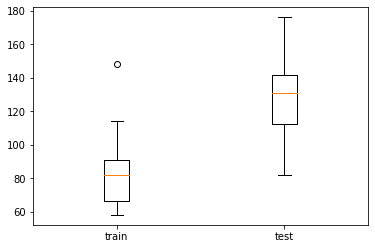

In [104]:
plt.boxplot([train_error, test_error], labels=["train", "test"])
plt.show()